In [1]:
import sys
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import multiprocessing as mp
import glob
import math
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity

In [17]:
BASE_DIR = 'data/train'
# BASE_DIR = os.path.abspath('C:/Users/tokar/Desktop/EyeQ/EyeQ_preprocess/original_crop')
OUT_DIR = 'train_winner'
IMG_SCALE_FOR_GAUSS = 500

In [3]:
images_paths = [os.path.basename(path) for path in glob.glob(BASE_DIR + '/*')]

In [4]:
processing_test_images = []
processing_test_images.append('19968_left.jpeg') # normal
processing_test_images.append('998_left.jpeg')
processing_test_images.append('10698_left.jpeg') # shifted to right
processing_test_images.append('10705_left.jpeg') # intensive red chanell
processing_test_images.append('10645_left.jpeg') # very poor quality
processing_test_images.append('10614_left.jpeg') # retina not fip
processing_test_images.append('10503_left.jpeg') # eclipse effect on the left and also vertical light borders(because of it radius was calculated bad)
processing_test_images.append('10510_left.jpeg') # pre-retinal hemorrhage
processing_test_images.append('10095_left.jpeg') # light pixels around retina
processing_test_images.append('10996_left.jpeg') # almost black image
processing_test_images.append('2695_left.jpeg')
processing_test_images.append('2785_left.jpeg')

In [26]:
def load_img(filename):
    img = cv2.imread(BASE_DIR + '/' + filename)
    return img

def resize_image_aspect_ratio(image, new_width=None, new_height=None):
    height, width = image.shape[:2]
    if new_width is not None and new_height is None:
        r = new_width/width
        new_height = int(height * r)
    elif new_width is None and new_height is not None:
        r = new_height/height
        new_width = int(width * r)
    new_image = cv2.resize(image, (new_width, new_height))
    return new_image

def resize(img):
    return cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)

# Mean color intensity in center row
def calc_mean(img):
    return img[img.shape[0] // 2, :, :].sum(1).mean()

def calc_black_area(img, threshold=35):
    # try calculate it like mean of first 10 columns and set threshold to it
    m = calc_mean(img)
#     print('Mean:', m)
    if m < threshold:
        threshold = 0
    maxs = np.max(img, axis=2)
    thsh = np.argwhere(maxs > threshold)
    # (y_min, x_min), (y_max, x_max)
    return (thsh[:,0].min(), thsh[:,1].min()), (thsh[:,0].max(), thsh[:,1].max())

def crop_by_points(img, point_min, point_max):
    return img[point_min[0]:point_max[0] , point_min[1]:point_max[1]]

def calc_radius_and_center(img):
    point_min, point_max = calc_black_area(img)
#     print('Min point:', point_min, 'Max point:', point_max)
    r = (point_max[1] - point_min[1]) // 2
    # if retina doesnt fit into image then center of it is at center of image
    if point_min[0] == 0:
        return r, (img.shape[0] // 2, point_min[1] + r)
    else:
        return r, (point_min[0] + r, point_min[1] + r)

# Shrink radius a little 
def fill_everything_out_of_radius(img, r, center):
    mask = np.full((img.shape[0], img.shape[1], 3), 0, dtype=np.uint8)
    cv2.circle(mask, (center[1], center[0]), int(r*0.9), (1,1,1), -1, 8, 0)
    return img * mask

def gaussian_filter(img):
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img,(0,0),img.shape[1] / 30), -4, 128)
    return img

def normalize(img):
    normalizedImg = np.zeros(img.shape)
    normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return normalizedImg

def apply_clahe(img, grid_size = 5):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_planes = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=1.5,tileGridSize=(grid_size,grid_size))
    lab_planes[0] = clahe.apply(lab_planes[0])
    img = cv2.merge(lab_planes)
    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
    return img

def process_img(img_name):
    img = load_img(img_name)
    # img = resize_image_aspect_ratio(img, new_height=700)
    # img = img[:, 5:-5, :]
#     print('Image shape after resizing:', img.shape[:2])
    # img = normalize(img)
    # img = apply_clahe(img)
    img = winner_processing(img)
    # r, center = calc_radius_and_center(img)      
    # print('Radius:', r, 'center:', center)
    # img = gaussian_filter(img)
    # img = fill_everything_out_of_radius(img, r, center)
    # point_min, point_max = calc_black_area(img, 0)
    # print('point_min:', point_min, 'point_max:', point_max)
    # img = crop_by_points(img, point_min, point_max)    
    # img = resize(img)
    return img

def scaleRadius(img, scale):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img,(0,0),fx=s,fy=s)

def winner_processing(img):
    scale = 300    
    #scaleimgtoagivenradius
    a = scaleRadius(img, scale)
    #subtractlocalmeancolor
    a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0,0), scale/30), -4, 128)
    #removeouter10%
    b = np.zeros(a.shape)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(scale*0.9),(1,1,1),-1,8,0)
    a = a*b + 128*(1-b)
    return a.astype(np.uint8)

def test_processing(images):    
    fig, m_axs = plt.subplots(len(images), 2, figsize = (32, 64))
    for i, img_path in enumerate(images):
        img_orig = load_img(img_path)
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB) 
        img_proc = process_img(img_path)
        img_proc = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB) 
        m_axs[i][0].imshow(img_orig)
        m_axs[i][0].set_title(img_path)
        m_axs[i][1].imshow(img_proc)

def showimg(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.imshow(img)
        
def test_img(img_name):
    img = process_img(img_name)
    showimg(img)

def plot_with_histograms(*images):
    fig, m_axs = plt.subplots(len(images),2, figsize=(13,len(images) * 6), squeeze=False)
    for i, img in enumerate(images):        
        m_axs[i][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        m_axs[i][1].hist(img[:,:,0].flatten(),256,[0,256], color = 'r', alpha=0.5)
        m_axs[i][1].hist(img[:,:,1].flatten(),256,[0,256], color = 'g', alpha=0.5)
        m_axs[i][1].hist(img[:,:,2].flatten(),256,[0,256], color = 'b', alpha=0.5)
        m_axs[i][1].set_ylim([0,50000])
    

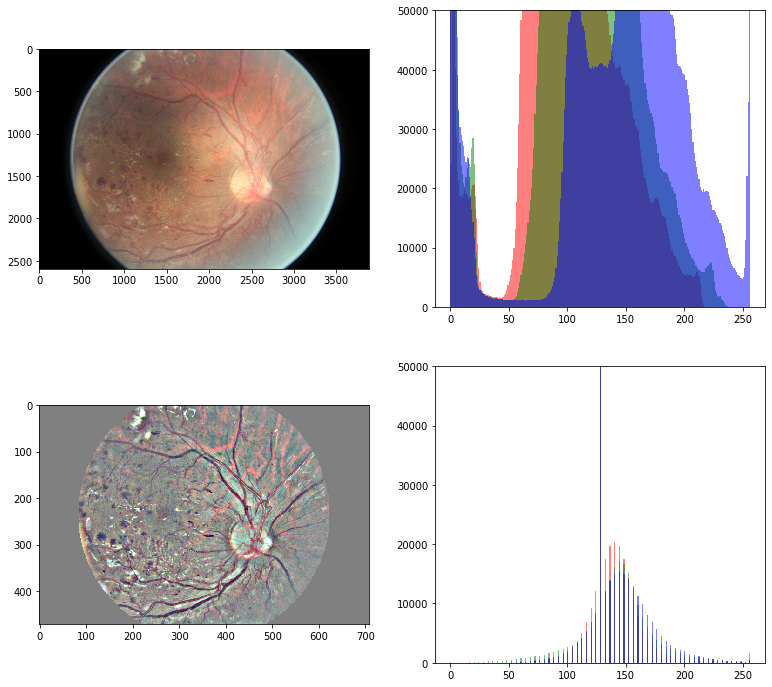

In [29]:
# test_processing(processing_test_images)
img_path = '16_left.jpeg'
org = load_img(img_path)
img = process_img(img_path)
plot_with_histograms(org, img)

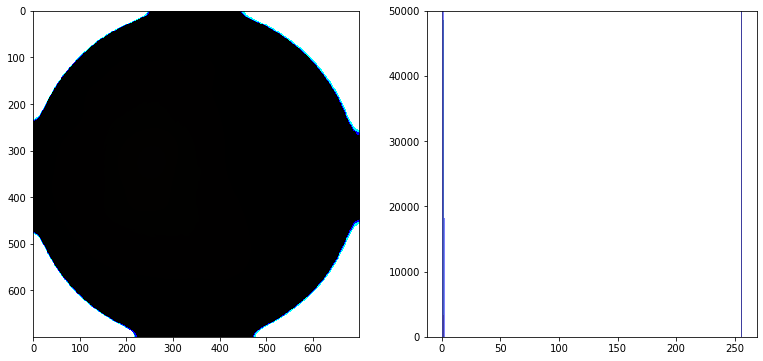

In [44]:
org = load_img('998_left.jpeg')
org = resize_image_aspect_ratio(org, new_height=700)

def normalize(img):
    return (img - img.mean()) / (img.std() + 1e-8).astype(np.uint8)

img = cv2.cvtColor(org, cv2.COLOR_BGR2HSV)
img = cv2.GaussianBlur(img,(0,0),img.shape[1] / 30)
img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
img = normalize(img).astype(np.uint8)
plot_with_histograms(img)

In [7]:
bgr = load_img('10503_left.jpeg')
# bgr = normalize(bgr)
bgr = apply_clahe(bgr)
# bgr[:,:,0] = (x - x.min()) / (x.max() - x.min())
# bgr[:,:,1] = bgr[:,:,1] - np.mean(bgr[:,:,1])
# bgr[:,:,2] = bgr[:,:,2] - np.mean(bgr[:,:,2])
# bgr = normalize(bgr).astype(np.uint8)
bgr2 = normalize(bgr2)
plot_with_histograms(bgr, bgr2)

NameError: name 'gridsize' is not defined

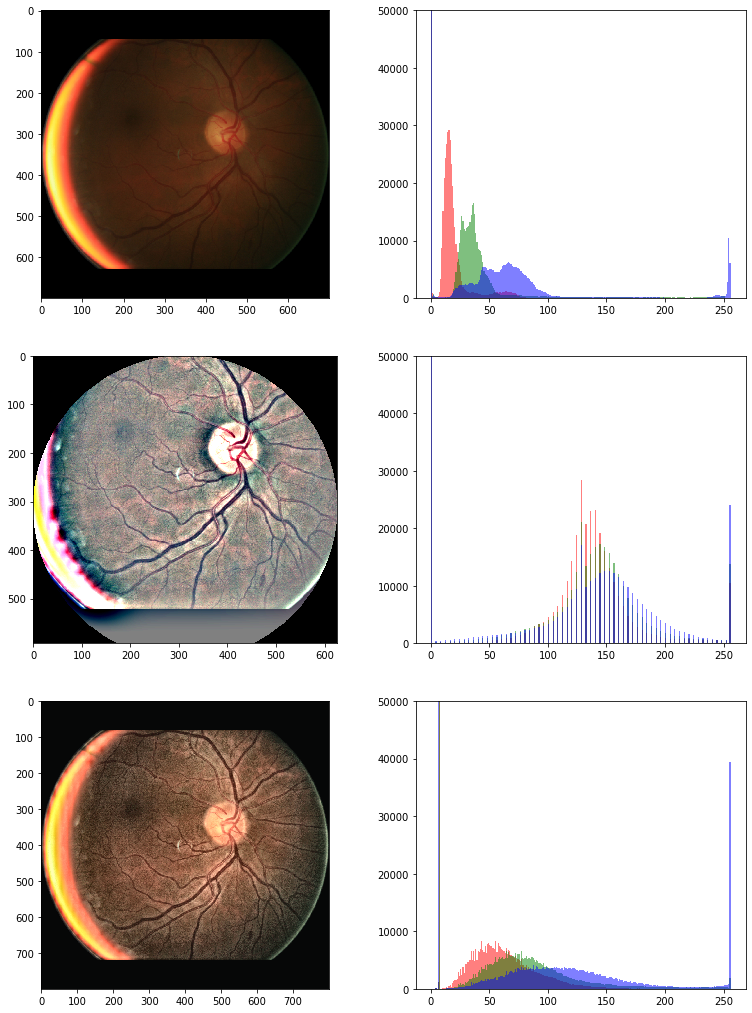

In [58]:
image_path = processing_test_images[len(processing_test_images) - 1]
image_path = processing_test_images[0]
image_path = '10503_left.jpeg'

org = load_img(image_path)
org = resize_image_aspect_ratio(org, new_height=700)
claheImg = normalize(org)
claheImg = apply_clahe(claheImg, 50)
r, center = calc_radius_and_center(claheImg)
claheImg = gaussian_filter(claheImg)
claheImg = fill_everything_out_of_radius(claheImg, r, center)
point_min, point_max = calc_black_area(claheImg, 0)
claheImg = crop_by_points(claheImg, point_min, point_max)   

img = process_img(image_path)
img = apply_clahe(img, 50)

plot_with_histograms(org, claheImg, img)


In [11]:
for fn in images_paths:
    try:
        img = process_img(fn)
        cv2.imwrite(os.path.join(OUT_DIR,fn), img)
    except KeyboardInterrupt:
        print('You cancelled the operation.')
        break
    except:
        print('The error occured during processing image:', fn)

In [8]:
list(zip([1,2], ['a','b','c']))

[(1, 'a'), (2, 'b')]

## Original preprocessing
[Source](http://scholar.google.cz/scholar_url?url=https://kaggle-forum-message-attachments.storage.googleapis.com/88655/2795/competitionreport.pdf&hl=en&sa=X&scisig=AAGBfm0vGsKIa3EEhTDn8VZSmliV6_3Hsg&nossl=1&oi=scholarr)

In [32]:
def scaleRadius(img,scale):
    x=img[img.shape[0]/2,:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale∗1.0/r
    return cv2.resize(img,(0,0),fx=s,fy=s)

scale=300
for f in glob.glob("train/∗.jpeg")+glob.glob("test/∗.jpeg"):
    try:
        a=cv2.imread(f)
        #scaleimgtoagivenradius
        a=scaleRadius(a,scale)
        #subtractlocalmeancolor
        a=cv2.addWeighted(a,4,
        cv2.GaussianBlur(a,(0,0),scale/30),−4,
        128)
        #removeouter10%
        b=numpy.zeros(a.shape)
        cv2.circle(b,(a.shape[1]/2,a.shape[0]/2),
        int(scale∗0.9),(1,1,1),−1,8,0)
        a=a∗b+128∗(1−b)
        cv2.imwrite(str(scale)+"_"+f,a)
    except:
        printf

SyntaxError: invalid character in identifier (<ipython-input-32-c6fbb33b80dd>, line 4)